### 28. juni
Arbeidstimer: 8t

Begynte å lese artiklene til Belking og Nikkaran som omhandler double descent. Siden den ene artikkelen bruker CNN leste jeg meg opp på det og laget et script som bruker CNN isteden. Dette tok mye lengre tid å kjøre!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision

In [2]:
num_epochs = 10
batch_size = 100
learning_rate = 0.01

In [3]:
# Loads the MNIST dataset from Pytorch
train_set = torchvision.datasets.MNIST('data', train=True,
                                       transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST('data', train=False,
                                      transform=transforms.ToTensor(), download=True)


In [4]:
class Data(Dataset):
    def __init__(self, dataset):
        self.x, self.y = dataset.data, dataset.targets
        self.x = self.x.unsqueeze(1).float() / 255.0

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]



In [5]:
train_ds = Data(train_set)
test_ds = Data(test_set)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [7]:
model = ConvNet()

In [8]:
# Defining loss and optimizer functions
optimizer = SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [9]:
# Creating test data
x_test = test_set.data.unsqueeze(1).float() / 255.0
y_test = test_set.targets

In [10]:
# Lists to store epochs, loss, accuracy, and average weight change for each epoch
epochs = []
losses = []
accuracy = []
avg_weight_changes = []

# Create a copy of the initial model state
initial_state = copy.deepcopy(model.state_dict())
# Create dictionaries to store the weight differences for each layer
# The weight difference is between one epoch and the next
layer_weight_differences = {layer_name: [] for layer_name, _ in model.named_parameters()}

for epoch in range(num_epochs):
    # Train the model
    N = len(train_dl)
    model.train()

    for i, (x_batch, y_batch) in enumerate(train_dl):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epochs.append(epoch + i / N)
        losses.append(loss.mean().item())

    # Evaluate the model
    model.eval()
    output = model(x_test)
    acc = (torch.argmax(output, 1) == y_test).float().mean()
    accuracy.append(acc.item())
    print(f"Epoch {epoch}, loss {loss}, accuracy {acc*100}")

    total_weight_change = 0
    total_weights = 0

    # Calculate weight difference for each layer
    for layer_name, layer_weights in model.named_parameters():
        # Select only weights and not the biases
        if "weight" in layer_name:
            # Define the previous weights
            prev_weights = initial_state[layer_name]
            # Define current weights
            current_weights = layer_weights.data
            difference = torch.abs(current_weights - prev_weights)
            # Calculate weight change in each layer
            layer_weight_differences[layer_name].append(difference.mean().item())

            # Calculate average weight change for all the layers
            weight_change = torch.abs(current_weights - prev_weights).sum().item()
            total_weight_change += weight_change
            total_weights += current_weights.numel()

    average_weight_change = total_weight_change / total_weights
    avg_weight_changes.append(average_weight_change)

    # Update initial state for the next epoch
    initial_state = copy.deepcopy(model.state_dict())


Epoch 0, loss 0.5971861481666565, accuracy 85.79999542236328
Epoch 1, loss 0.2358606457710266, accuracy 91.54000091552734
Epoch 2, loss 0.22805364429950714, accuracy 93.22000122070312
Epoch 3, loss 0.3172447979450226, accuracy 94.30000305175781
Epoch 4, loss 0.14271271228790283, accuracy 95.19000244140625
Epoch 5, loss 0.1875920444726944, accuracy 95.80000305175781
Epoch 6, loss 0.1176351010799408, accuracy 96.34000396728516
Epoch 7, loss 0.10096421837806702, accuracy 96.66999816894531
Epoch 8, loss 0.04444033280014992, accuracy 97.08999633789062
Epoch 9, loss 0.0822257548570633, accuracy 97.39999389648438


In [11]:
# Turning lists to arrays for flexibility
epochs = np.array(epochs)
losses = np.array(losses)
accuracy = np.array(accuracy)
average_weight_changes = np.array(avg_weight_changes)

# Reshaping before plotting to get the same dimensions
epoch_data_avgd = epochs.reshape(num_epochs, -1).mean(axis=1)
loss_data_avgd = losses.reshape(num_epochs, -1).mean(axis=1)
accuracy = accuracy.reshape(num_epochs, -1).mean(axis=1)

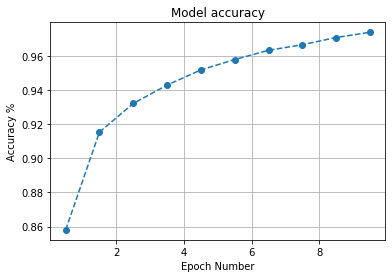

In [12]:
plt.plot(epoch_data_avgd, accuracy, "o--")
plt.grid()
plt.title("Model accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy %")
plt.show()    

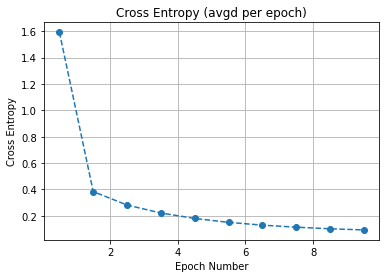

In [13]:
plt.plot(epoch_data_avgd, loss_data_avgd, "o--")
plt.grid()
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (avgd per epoch)")
plt.show()

Layer: conv1.weight
Epoch 0: Average Weight Difference: 0.059415534138679504
Epoch 1: Average Weight Difference: 0.01498340256512165
Epoch 2: Average Weight Difference: 0.007386151235550642
Epoch 3: Average Weight Difference: 0.006767354439944029
Epoch 4: Average Weight Difference: 0.005837159231305122
Epoch 5: Average Weight Difference: 0.0051924679428339005
Epoch 6: Average Weight Difference: 0.00457378476858139
Epoch 7: Average Weight Difference: 0.003940983209758997
Epoch 8: Average Weight Difference: 0.0036070661153644323
Epoch 9: Average Weight Difference: 0.0031489154789596796
Layer: conv2.weight
Epoch 0: Average Weight Difference: 0.009609092026948929
Epoch 1: Average Weight Difference: 0.0029662824235856533
Epoch 2: Average Weight Difference: 0.0020396625623106956
Epoch 3: Average Weight Difference: 0.0017808611737564206
Epoch 4: Average Weight Difference: 0.0015305994311347604
Epoch 5: Average Weight Difference: 0.0013168166624382138
Epoch 6: Average Weight Difference: 0.0011

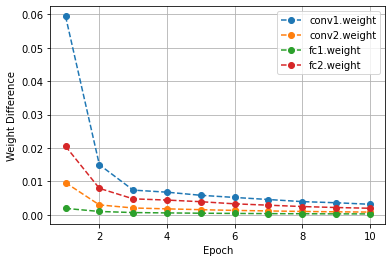

In [14]:
# Print the average weight differences for each layer for each epoch
for layer_name, weight_differences in layer_weight_differences.items():
    if "weight" in layer_name:
        print(f"Layer: {layer_name}")
        for epoch, difference in enumerate(weight_differences):
            print(f"Epoch {epoch}: Average Weight Difference: {difference}")

# Get the max number of weight differences across all layers
max_weight_differences = max(len(weight_differences) for weight_differences in layer_weight_differences.values())

# Generate the x-axis epoch data
epoch_data_avgd = np.linspace(1, num_epochs, max_weight_differences)

# Plot epoch vs. weight difference for each layer
for layer_name, weight_differences in layer_weight_differences.items():
    if "weight" in layer_name:
        plt.plot(epoch_data_avgd[:len(weight_differences)], weight_differences, "o--", label=layer_name)

plt.xlabel("Epoch")
plt.ylabel("Weight Difference")
plt.grid()
plt.legend()
plt.show()

Begynte på et oppsummeringsdokument i latex hvor jeg forklarer MLP, CNN og de ulike komponentene av nettverkene. Hentet info fra https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939. Her er dokumentet flyttet hit:

### Typer av nevrale nettverk, MLP/CNN
Et nevralt nettverk kan bygges opp på ulike måter. En metode, og kanskje den enkleste metoden å bygge et nevralt nettverk på er MLP (multilayer perceptrons). Et perseptron er et 1-lags feed forward nevralt nettverk. At det er et feed forward nettverk betyr bare at informasjonsflyten er i en retning, fra input-lag til output-lag. Et MLP-nettverk består 3 lag som inkluderer input-lag, skjult lag og output lag. Dersom nettverket har mer enn ett skjult lag kalles det et deep ANN (artificial neural network). MLP er en type feed forward nettverk. Hvert nevron i hvert lag er koblet til hvert nevron i det følgende laget. Det bruker ikke-lineære aktiveringsfunksjoner slik som sigmoid eller ReLU-funksjonen som gjør at nettverket kan lære komplekse mønstre. 

En annen type feed forward nettverk er CNN (concolutional neural network). CNN skiller seg fra MLP ved å inneholde konvolusjonslag og  pooling lag i tillegg til fullt tilkoblede lag og aktiveringsfunksjon som MLP også har. 
CNN er spesielt effektive for bildeklassifisering og brukes derfor ofte til MNIST-datasettet.

### MLPSs
MLP-nettverk (Multi-layer perceptron) er en type nevralt nettverk hvor nevronene er organisert i lag.
$$a^{L} = \sigma(w^{L}a^{(L-1)} + b^L)$$

Vektene i nevrale nettverk representerer styrken på signalet som sendes fra et nevron i et lag til et annet nevron i det neste laget. Hver kobling mellom nevronene i nettverket har en assosiert vekt. Vektene er lærbare parametre som justeres under trening av nettverket. Jo høyere verdien til vekten er jo større påvirkning har det første nevronet i koblingen på det andre nevronet i koblingen.

### CNNs

Konvolusjonslagene behandler mesteparten av dataen. I lagene utføres et prikkprodukt mellom to matriser, hvor den ene matrisen består av lærbare vekter (kernel/filter) og den andre matrisen er en liten del av input-bildet (eks 3x3 piksler). Ved forward pass "slider" kernelen over bildet og alle prikkproduktene lagres i det som kalles et activation map/feature map, en 2d representasjon av bildet med responsen til kernel ved hver posisjon i bildet. Ved å bruke flere filter/kernels kan nettverket oppdage mønster i bildet. I pooling-laget "slider" vi et to-dimensjonalt filter over feature mappet og finner gjennomsnitt/max-verdi i de nærliggende regionene. Ved max-pooling finner man max-verdien innenfor et område på eks. et 2x2-vindu av feature-mappet. På denne måten reduserer man dimensjonen til feature mappet og reduserer antallet parametre som nettverket må lære. De fullt tilkoblede lagene har som ved MLPs nevroner som i hvert lag er koblet til hvert nevron i det følgende laget. CNN bruker også en aktiveringsfunksjon som introduserer ikke-linearitet til de lineære konvolusjonslagene. En aktiveringsfunksjon som ofte brukes er ReLU (the Rectified Linear Unit). ReLu er mer pålitelig enn sigmoid- og tanh-funksjonene og akselererer konvergensen 6 ganger raskere.

Ved CNN brukes ofte padding. Padding er når man legger til en ekstra bord av piksler på utsiden av input-bildet før man gjør en konvolusjon. Det øker størrelsen av input-laget og gjør at feature mappet har samme dimensjon som input-bildet har. Feature mappet blir typisk litt mindre pga konvolusjonsoperasjonene, noe man forhindrer ved padding. Det som skjer er at når filteret i konvolusjonslaget beveger seg langs input-grensene til bildet vil filteret bevege seg utenfor grensene dersom det ikke er noe padding som minsker bildet. Ved padding beholder man derfor også grenseinformasjonen til bildene.

### Fordeler med CNN
Fordelen med konvolusjonslag er at ved bruk av kernel får man sparse interraction siden det blir færre parametere å lagre og minnekravene blir derfor lavere og effektiviteten blir høyere. Sammenlignet med MLPs hvor hvert element i vektmatrisen kun brukes en gang er at konvolusjonslagene har felles parametre som er lagret i kernel. Det medfører at et endring i input vil endre output på samme vis.